In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats.mstats as ssm

%matplotlib inline

## Data cleaning: 

Data cleaning and Assumptions

- Drop items whose `rater` column is Nan. 
- Convert the career statistics to their expectations per game. It is more reasonable to compare their expectations. Image a player who play 20 games and 50 games with same performance(temper/position/goals/referee...), we should classifier them to same class. The total statistics will be very different while the averaged stats will be similar.
- Average the rater's score and binarize them to 0 (light skin) or 1 (dark skin)
- Convert country/club name to index.
- Trucate the birthday to the year. We assume that all the players enter leagues at similar age. Thus the information of birthday makes referees' creterion comparable overtime. For example, one action is considered admissible during a period of time but will get a yellow card in other time. If we compare the number of red cards of white players in 1980s with those of black players in 2010s, we may get wrong conclusions.
- Features like `photoID`, `player` is not used because their information are covered by `player-short` and `rater`
- stats like `meanAIT` are weighted with the number of games in a referee-player dyad. Togethor with `games`, the new stats will represent the total(average) `AIT` a player faced.

In [3]:
# load the data
filename = 'CrowdstormingDataJuly1st.csv'
df_all = pd.read_csv(filename)

df_all.dropna(inplace=True)

Feature Engineering

In [4]:
df_all['Skin'] = ((df_all['rater1'] + df_all['rater2']) > 1 ).astype(int)
df_all['totalCards'] = (df_all['redCards'] + df_all['yellowCards'] + df_all['yellowReds'])
df_all['weightIAT'] = df_all['meanIAT'] * df_all['games']
df_all['weightExp'] = df_all['meanExp'] * df_all['games']

In [5]:
# replace birthday by the birth year
df_all['birthday'] = df_all.apply(lambda x: x.loc['birthday'].split('.')[2], axis=1).astype(int)

# replace country name by number labels in order to classify
dic_country = {'Spain':0, 'France':1, 'England':2, 'Germany':3}
df_all['leagueCountry'] = df_all.apply(lambda x: dic_country[x.loc['leagueCountry']], axis=1)

# replace club name by number labels in order to classify
club_name = df_all['club'].unique()
num_of_clubs = len(club_name)
club_index = np.arange(0, num_of_clubs)
club_name_index_map = dict(zip(club_name, club_index))
df_all['club'] = df_all.apply(lambda x: club_name_index_map[x.loc['club']], axis=1)

In [6]:
# replace position name by number labels in order to classify
position_name = df_all['position'].unique()
num_of_position = len(position_name)
position_index = np.arange(0, num_of_position)
position_name_index_map = dict(zip(position_name,position_index))

df_all['position'] = df_all.apply(lambda x: position_name_index_map[x.loc['position']], axis=1)

In [7]:
rev_position_name_index_map = {v:k for k, v in position_name_index_map.items()}

In [8]:
df_all.head() 

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,Skin,totalCards,weightIAT,weightExp
0,lucas-wilchez,Lucas Wilchez,0,0,1983,177.0,72.0,0,1,0,...,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0,0,0.326391,0.396000
1,john-utaka,John Utaka,1,1,1982,179.0,82.0,1,1,0,...,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,1,1,0.203375,-0.204082
5,aaron-hughes,Aaron Hughes,2,2,1979,182.0,71.0,2,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0,0,0.325185,0.538462
6,aleksandar-kolarov,Aleksandar Kolarov,3,2,1985,187.0,80.0,3,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0,0,0.325185,0.538462
7,alexander-tettey,Alexander Tettey,4,2,1986,180.0,68.0,4,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1,0,0.325185,0.538462


#### Create a new dataframe of size (`num_player`, `num_feaures`) of each player.

In [9]:
rev_club_name_index_map = {v:k for k,v in club_name_index_map.items()}

In [10]:
# Aggragate player's stats by summing
df_player = df_all[['playerShort','totalCards', 'redCards', 'yellowCards', 
                    'yellowReds', 'victories', 'ties', 'weightIAT', 'weightExp',
                    'defeats', 'goals', 'games']].groupby('playerShort').sum()

# the birthday, position, skin are the same for each player, so using `mean` will not change.
df_player[['birthday','position', 'skin', 'club', 'leagueCountry', 'height','weight']] = df_all[
    ['playerShort', 'birthday', 'position', 'Skin', 'club', 'leagueCountry'
    , 'height','weight']].groupby('playerShort').mean()

#### Create a new dataframe of each player with stats per game

In [11]:
df_ave = df_player.copy()

averaged_list = ['totalCards','yellowCards', 'yellowReds', 'redCards', 'victories', 'ties', 
                 'defeats', 'goals', 'weightIAT', 'weightExp']
for feature in averaged_list:
    df_ave[feature] = df_ave[feature]/df_ave['games']

Analyse the skin with the red/yellow cards they receive. From this simple stats, we found the number of cards received per game are similar. Light skin player receives a little more yellow cards, while dark skin player receive more red cards.

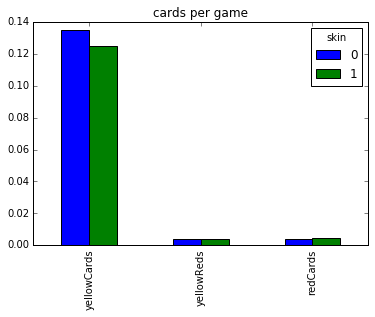

In [12]:
skin_x_cards = df_player.groupby('skin').sum()[['yellowCards', 'yellowReds', 'redCards', 'games']]

for card in ['yellowCards', 'yellowReds', 'redCards']:
    skin_x_cards[card] = skin_x_cards[card] / skin_x_cards['games']

skin_x_cards[['yellowCards', 'yellowReds', 'redCards']].transpose().plot(kind='bar')
plt.title('cards per game')
plt.show()

### classification objective visionlization

Compare the number of players with their age and skin color. We found the number of player with light skin color is much more than dark skin. As the portion of young players have `light` skin than those born in 1980s, it is reasonable to think many dark skin player come from countries outside this 4 leagues.

More importantly, we will have to choose an appropriate metric which measures the `desired` accuracy and a better learning option (use `class_weight=balanced_subsample` when we define classifier). In this case, we use `F1` score to choose a model as it garauntees both precision and recall. In this way, we can leviate the effect of **imbalanceness**.

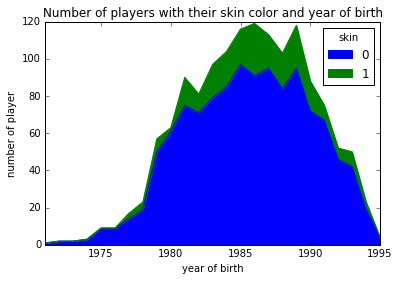

In [13]:
rater_average = df_player[['skin', 'birthday', 'games']]
rater_birth_count = rater_average.groupby(['skin', 'birthday']).count()
rater_birth_count = rater_birth_count.reset_index()
pivoted_rater_birth_count = rater_birth_count.pivot(columns='skin', values='games', index='birthday').fillna(0)
pivoted_rater_birth_count.plot(kind='area')
plt.ylabel('number of player')
plt.xlabel('year of birth')
plt.title('Number of players with their skin color and year of birth')
plt.show()

#### Positions

Some positions are more likely to get red cards than the others. We first take a look at their distributions.

In [14]:
position_x_skin_df = df_player.groupby(['position', 'skin']).sum()
for feature in ['totalCards', 'redCards', 'yellowCards', 'yellowReds', 'victories',
               'ties', 'weightIAT', 'weightExp', 'defeats', 'goals']:
    position_x_skin_df[feature] = position_x_skin_df[feature]/position_x_skin_df['games']

In [15]:
position_x_skin_df.head()

totalCards  redCards  yellowCards  yellowReds  victories  \
position skin                                                             
0        0       0.128570  0.002584     0.123232    0.002754   0.467288   
         1       0.135902  0.001605     0.130551    0.003745   0.407170   
1        0       0.114078  0.004108     0.108010    0.001960   0.477689   
         1       0.101413  0.003795     0.095298    0.002319   0.444444   
2        0       0.176751  0.006642     0.164081    0.006028   0.459571   

                   ties  weightIAT  weightExp   defeats     goals  games  \
position skin                                                              
0        0     0.229631   0.347319   0.446752  0.303081  0.161997  29408   
         1     0.246656   0.345080   0.416082  0.346174  0.167469   1869   
1        0     0.229742   0.350241   0.474613  0.292569  0.270911  10712   
         1     0.245414   0.337989   0.388015  0.310141  0.186802   4743   
2        0     0.235413   0.345425   0.439991  0.305016  0.053137  53748   

               birthday  club  leagueCountry   height   weight  
position skin                                                   
0        0       236445  4560            205  21094.0   8504.0  
         1        15900   293              7   1434.0    594.0  
1        0        79463  1708             58   7102.0   2902.0  
         1        31757   496             21   2844.0   1173.0  
2        0       418858  8218            342  39519.0  17037.0

In [16]:
position_x_skin_redCards = position_x_skin_df.reset_index()
position_x_skin_redCards['position'] = position_x_skin_redCards.apply(
    lambda x: rev_position_name_index_map[x.loc['position']], axis=1)

position_x_skin_redCards = position_x_skin_redCards.pivot(
    values='redCards', columns='skin', index='position')

In some positions like `center Back`, `Goal Keepers` and `right winger`, `right fullback`

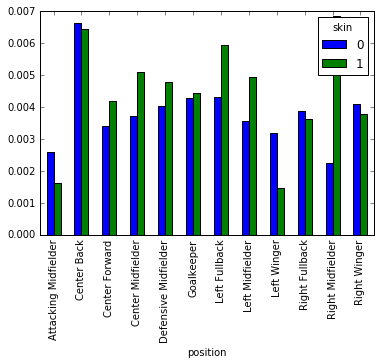

In [17]:
position_x_skin_redCards.plot(kind='bar')

#### Groupby Referees

In [18]:
df_all.ix[:5, 13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,Skin,totalCards,weightIAT,weightExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0,0,0.326391,0.396000
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,1,1,0.203375,-0.204082
5,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0,0,0.325185,0.538462


In [19]:
df_all.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'Skin', 'totalCards', 'weightIAT',
       'weightExp'],
      dtype='object')

In [20]:
ref_df1 = df_all.groupby('refNum').sum()[['games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards']]
ref_df2 = df_all.groupby('refNum').mean()[['refCountry', 'meanIAT', 'nIAT', 'seIAT', 
                                 'meanExp', 'nExp', 'seExp']]

ref_df = pd.concat([ref_df1, ref_df2], axis=1)
ref_df.head()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
refNum,,,,,,,,,,,,,,,
1,1,0,0,1,0,0,0,0,1.0,0.326391,712.0,0.000564,0.396000,750.0,0.002696
2,1,0,0,1,0,1,0,0,2.0,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
4,32,22,4,6,2,2,0,0,4.0,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,5,4,0,1,1,0,0,0,6.0,0.322177,140.0,0.003344,0.117647,136.0,0.013721
7,77,32,17,28,9,8,0,1,7.0,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586


In [21]:
ref_df = df_all.groupby(['refNum', 'Skin']).sum()
ref_df = ref_df[ref_df.games > 22]
ref_df['redCards'] = ref_df['redCards']/ref_df['games']

In [22]:
df_ave.columns

Index(['totalCards', 'redCards', 'yellowCards', 'yellowReds', 'victories',
       'ties', 'weightIAT', 'weightExp', 'defeats', 'goals', 'games',
       'birthday', 'position', 'skin', 'club', 'leagueCountry', 'height',
       'weight'],
      dtype='object')

## Assignment 1

We first deal with the overfitting problem. Given data contains 2 rater's score for skin darkness and we are required to train a classifier to estimate player's skin color from other feature. Since we cannot judge whether our estimation is correct or not for those which does not have the rater's score, we decide to drop these data and we use the rest of the data (named *training_data_x*) to train our classifier. 

We observe that there is a certain amount of rater score for the same player. If we simply randomly partition *training_data_x*, both the training data and the testing data will high likely to contain the rater score for the same player, then the classifier will check player's *birthday*, *height*, *weight* in order to verify the player and use the result from training data to testing data, which will give us high *clf_score*. 

However, this is not a faire classifier and we ignore all other features apart from three features mentioned above. Through a precise discussion and brain storm, we figure out that we should group the data by *playerShort* and get the mean value. Again, we cannot calculate the mean value of the string, such as *club, leagueCountry, refNum, refCountry, Alpha_3*, even if we label these string by unique number.

Add features like `clubs` into df_new

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [24]:
def cross_validation(name_list, K):
    np.random.shuffle(name_list)
    num_train = len(name_list) // K
    name_list = np.array(name_list)
    for i in range(K):
        te = np.arange(i * num_train, (i+1)*num_train)
        tr = [i for i in range(len(name_list)) if i not in te]
        yield name_list[tr], name_list[te]

In [25]:
def shuffle_names(name_list, ratio):
    np.random.shuffle(name_list)
    num_train = int(len(name_list) * ratio)
    return name_list[:num_train], name_list[num_train:]

### overfitting curve

To see the overfitting phenomenon, we groupby the dataframe with their name and aggregate the dyad information. This classifier performs very good on the trainging set (almost  99%) as the classifier is able to create enough trees to remember every player. 

However, this classifier behaves not as good on the test sets around (85%). The gap between training error and testing error is about 15% which is pretty large. Thus our model know have overfitting the datasets.

In fact, this classifier is useless if we checkout the `f1 score` and fusion matrix, we will find the `f1 score` is very small and the fusion matrix shows we have assgin new datapoints to `light skin`. It means our model is way too simple.

In [26]:
featuer_list1 = ['totalCards', 'redCards', 'yellowCards', 'yellowReds', 'victories',
       'ties', 'weightIAT', 'weightExp', 'defeats', 'goals', 'games',
       'birthday', 'position', 'club', 'leagueCountry', 'height','weight']
training_data_player_x = df_player[featuer_list1]
training_data_player_y = df_player['skin']

In [27]:
clf = RandomForestClassifier(n_estimators=30, class_weight="balanced_subsample")
portion = 0.80
n = training_data_player_x.shape[0]
temp_set = np.random.permutation(range(n))
training_idx = [i for i in temp_set if i < n * portion]
test_idx = [i for i in temp_set if i > n * portion]

x_tr = training_data_player_x.iloc[training_idx]
y_tr = training_data_player_y.iloc[training_idx]
x_te = training_data_player_x.iloc[test_idx]
y_te = training_data_player_y.iloc[test_idx]

clf.fit(X=x_tr, y=y_tr)
y_pred = clf.predict(x_te)
print("training error = ", clf.score(x_tr, y_tr), ", test error = ", clf.score(x_te, y_te))

training error =  0.995598591549 , test error =  0.858657243816


In [28]:
print("F1 score = ", f1_score(y_true=y_te,y_pred=y_pred))

F1 score =  0.130434782609


In [31]:
print("fusion matrix for \n", confusion_matrix(y_true=y_te,y_pred=y_pred))

fusion matrix for 
 [[240   4]
 [ 36   3]]


### Reduce Overfitting

#### Approach 1
One way to reduce overfitting is to reduce the noise our classifier obtained from training dataset. In the above overfitting example, we didn't limit the maximum depth of randomforest, meaning the classifier can create split node as much as it want. It also means that random noise can also be used to split node. 

Beside, the number of estimators we use is very large (`30`). It allows the classifier to choose the model overfit the datasets rather than the inner structure.

Thus, we are going to limit the maximum depth and number of estimators. We will use cross validation to show our strategy improves the performance

In [201]:
def reduce_overfitting(n_estimators, max_depth, training_data_player_x, training_data_player_y, K=5):
    prediction_list = []
    training_score_list = []
    testing_score_list = []
    recall_score_list = []
    name_list = training_data_player_x.reset_index()['playerShort'].unique()
    for tr_idx, te_idx in cross_validation(name_list, K=K):
        x_tr = training_data_player_x.loc[tr_idx]
        y_tr = training_data_player_y.loc[tr_idx]
        x_te = training_data_player_x.loc[te_idx]
        y_te = training_data_player_y.loc[te_idx]

        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight="balanced_subsample")

        clf.fit(X=x_tr, y=y_tr)
        y_pred = clf.predict(x_te)
        prediction_list.append(f1_score(y_true=y_te, y_pred=y_pred))
        training_score_list.append(clf.score(x_tr, y_tr))
        testing_score_list.append(clf.score(x_te, y_te))
        recall_score_list.append(recall_score(y_true=y_te, y_pred=y_pred))
    #     print("training error = ", training_score_list[-1], ", test error = ", testing_score_list[-1])
    #     print("fusion matrix  = \n", confusion_matrix(y_true=y_te, y_pred=y_pred))
    print("n_estimators = {:>3}, max_depth ={:>3}, f1 score = {:6.3}".format(n_estimators, max_depth, np.mean(np.array(prediction_list))))
    print("training = {:6.3}, testing = {:6.3}, recall = {:6.3}".format(np.mean(np.array(training_score_list)), np.mean(np.array(testing_score_list)),np.mean(np.array(recall_score_list))))
    
    return clf, np.mean(np.array(prediction_list)), np.mean(np.array(training_score_list)), np.mean(np.array(testing_score_list)),np.mean(np.array(recall_score_list))

In [176]:
for n_estimators in range(8, 16,2):
    for max_depth in range(1, 10):
        reduce_overfitting(n_estimators, max_depth,training_data_player_x, training_data_player_y)

n_estimators =   8, max_depth =  1, f1 score =  0.311
training =  0.565, testing =  0.545, recall =  0.671
n_estimators =   8, max_depth =  2, f1 score =   0.33
training =  0.623, testing =  0.607, recall =  0.617
n_estimators =   8, max_depth =  3, f1 score =  0.355
training =  0.675, testing =  0.642, recall =  0.637
n_estimators =   8, max_depth =  4, f1 score =  0.341
training =  0.729, testing =  0.673, recall =  0.524
n_estimators =   8, max_depth =  5, f1 score =  0.361
training =  0.786, testing =  0.718, recall =  0.507
n_estimators =   8, max_depth =  6, f1 score =  0.362
training =  0.828, testing =  0.748, recall =   0.47
n_estimators =   8, max_depth =  7, f1 score =  0.341
training =  0.871, testing =  0.761, recall =  0.405
n_estimators =   8, max_depth =  8, f1 score =  0.346
training =  0.893, testing =  0.776, recall =  0.388
n_estimators =   8, max_depth =  9, f1 score =  0.343
training =  0.926, testing =  0.796, recall =  0.341
n_estimators =  10, max_depth =  1, f

As we can see, by choosing a better parameter, the overfitting can be reduced 

n_estimators =  10, max_depth =  8, f1 score =  0.324
training =  0.921, testing =  0.787, recall =   0.32


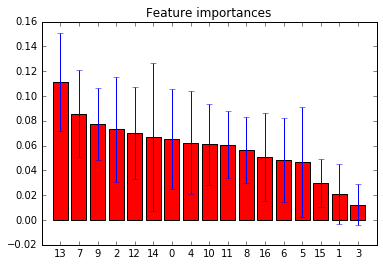

In [136]:
n_estimators=10
max_depth=8
clf,_,_,_,_ = reduce_overfitting(n_estimators, max_depth, training_data_player_x, training_data_player_y)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(training_data_player_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(training_data_player_x.shape[1]), indices)
plt.xlim([-1, training_data_player_x.shape[1]])
plt.show()

#### If we drop feature even before feeding data

The importances of features may change locally, but the overall order is similar.

n_estimators =  10, max_depth =  8, f1 score =  0.195
training =  0.905, testing =  0.763, recall =  0.189


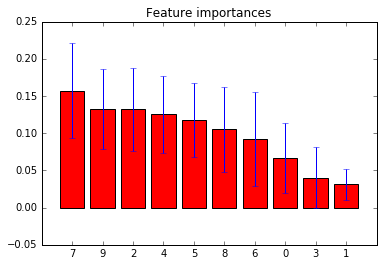

In [137]:
n_estimators=10
max_depth=8

feature_sets = np.arange(10)
training_datasets = training_data_player_x.ix[:, feature_sets]
clf,_,_,_,_ = reduce_overfitting(n_estimators, max_depth, training_datasets, training_data_player_y)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(training_datasets.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(training_datasets.shape[1]), indices)
plt.xlim([-1, training_datasets.shape[1]])
plt.show()

#### Approach 2 (Training dyad)

Gathering more data is a very common way to reduce data. Unfortuntly, we can't get gather more information of player due to time limitation. However, we can train the player-referee dyad directly with careful choice of features.

Let's take each dyad as training example and split the whole dataframe into 2 parts: one for training and one for testing.

The key issue here is to avoid introducing specific information about a player, say the `club`, `leagueCountry`, `height` and `weight`. Otherwise, these information try to find the exact player rather than try to find out the relation between `player` with dyad

In [84]:
def get_equal_index(df):
    dark_idx  = df[df.Skin == 1].index.unique()
    light_idx = df[df.Skin == 0].index.unique()
    equal_light_idx = np.random.choice(light_idx, light_idx.shape[0], replace=False)
    return dark_idx.union(equal_light_idx)

In [115]:
columns_to_be_averaged = ['victories', 'ties','defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']
column_name_not_training = [ 'player', 'refNum', 'refCountry', 
                            'Alpha_3', 'rater1', 'rater2', 'photoID', 
                            'club', 'leagueCountry', 'birthday', 'height', 
                            'weight', 'position', 'totalCards']
column_name_training = [i for i in df_all.columns if i not in column_name_not_training]
training_df = df_all[df_all.games > 1][column_name_training].copy()

for col in columns_to_be_averaged:
    training_df[col] = training_df[col] / training_df['games']
    
# del training_df['games']
training_df.set_index('playerShort', inplace=True)
column_name_training.remove('Skin')
column_name_training.remove('playerShort')

In [116]:
indices = get_equal_index(training_df)

cols = column_name_training
training_data_x = training_df.loc[indices][cols]
training_data_y = training_df.loc[indices]['Skin']
player_name_list = list(set(training_data_x.index))

#### Influence of different set of parameters to RandomForestClassifier. 

This method may not perform so well as each player will be feed to the classfier several times. But the overfitting is greatly reduced.

In [127]:
n_estimators = 30
max_features = 10
clf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, class_weight="balanced_subsample")

portion = 0.9
n = training_data_x.shape[0]
temp_set = np.random.permutation(range(n))
training_idx = [i for i in temp_set if i < n * portion]
test_idx = [i for i in temp_set if i > n * portion]

x_tr = training_data_x.iloc[training_idx]
y_tr = training_data_y.iloc[training_idx]
x_te = training_data_x.iloc[test_idx]
y_te = training_data_y.iloc[test_idx]

clf.fit(X=x_tr, y=y_tr)
y_pred = clf.predict(x_te)
#         print("fusion matrix for ", confusion_matrix(y_true=y_te,y_pred=y_pred))
tmp_f1.append(f1_score(y_true=y_te,y_pred=y_pred))        
tmp_tr.append(clf.score(x_tr, y_tr))
tmp_te.append(clf.score(x_te, y_te))
print("f1_score = ", f1_score(y_true=y_te,y_pred=y_pred), 
      ", training error = ", tmp_tr[-1], ", test error = ", tmp_te[-1])

f1_score =  0.295691609977 , training error =  0.792390021096 , test error =  0.729442508711


## Bonus

Using the first approach, plot the learning learning curve.

Remark: As 20 fold of cross validation is time consuming and can cause high varaiance (as training sets are very similar), we decide to use 5 folded crossvalidation which is used most often.

In [224]:
def name_range(df, ratio):
    """Select a set of names for training and splitting"""
    names = df.index
    n = df.shape[0]
    idx = np.random.permutation(np.arange(n))[:int(n*ratio)]
    return names[idx]

In [225]:
n_estimators=20
max_depth=10

train_error_list = []
test_error_list = []
problem_size_list = []

for ratio in np.linspace(0.3, 0.9, num=10):
    names = name_range(training_data_player_x, ratio)
    _, _, train_error, test_error, _ = reduce_overfitting(n_estimators, max_depth, training_data_player_x.loc[names], 
                                                     training_data_player_y.loc[names])
    train_error_list.append(train_error)
    test_error_list.append(test_error)
    problem_size_list.append(len(names))

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


n_estimators =  20, max_depth = 10, f1 score = 0.0308
training =  0.992, testing =  0.824, recall =  0.025
n_estimators =  20, max_depth = 10, f1 score =   0.15
training =  0.994, testing =  0.838, recall = 0.0958
n_estimators =  20, max_depth = 10, f1 score =  0.162
training =  0.993, testing =  0.848, recall =  0.108
n_estimators =  20, max_depth = 10, f1 score =  0.204
training =   0.99, testing =  0.823, recall =  0.137
n_estimators =  20, max_depth = 10, f1 score =  0.219
training =  0.986, testing =  0.825, recall =  0.156
n_estimators =  20, max_depth = 10, f1 score =  0.199
training =  0.988, testing =  0.837, recall =  0.134
n_estimators =  20, max_depth = 10, f1 score =  0.281
training =  0.985, testing =  0.845, recall =  0.189
n_estimators =  20, max_depth = 10, f1 score =  0.324
training =  0.982, testing =  0.841, recall =  0.237
n_estimators =  20, max_depth = 10, f1 score =  0.328
training =  0.978, testing =  0.837, recall =  0.248
n_estimators =  20, max_depth = 10, f

We can see the test error is decreasing while the testing error is increasing. 

This is because with the growing of training sets, classifier loses the accuracy for each datapoint in order to fit more data. At the same time, with more datapoints, classifier can filter out noise better.

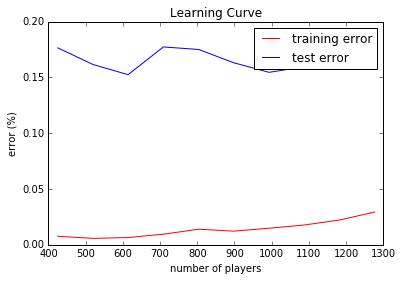

In [227]:
plt.figure()
plt.plot(problem_size_list, 1-np.array(train_error_list), 'r',label='training error')
plt.plot(problem_size_list, 1-np.array(test_error_list), 'b',label='test error')
plt.title("Learning Curve")
plt.xlabel("number of players")
plt.ylabel("error (%)")
plt.legend()
plt.show()

### feature importance

We partition the training data into two subsets, one called \{x_tr, t_tr\}, the other is called \{x_te, y_te\}. We perform training on \{x_tr, t_tr\}, then we compute the accuracy score on set \{x_te, y_te\}.  Later, we compute the feature importance and select the most important 5 features, and we do cross validation on set \{x_te, y_te\} only using these 5 features. As shown below, the difference between accuracy score on whole set of \{x_te, y_te\} and cross validation score on 5 features of \{x_te, y_te\} is only 0.05. It shows that these 5 feature are indeed play an significant role on the skin estimation.

## Assignment 2

In [ ]:
# load the data
filename = 'CrowdstormingDataJuly1st.csv'
df2 = pd.read_csv(filename)

In [ ]:
df_new.ix[:4,:13]

In [ ]:
df_new.ix[:4,13:]

In [ ]:
df_new['rater_average'] = (df_new['rater_average']>0.5).astype(int)

In [ ]:
df_new_copy = df_new.copy()

In [ ]:
del df_new_copy['birthday']

In [ ]:
del df_new_copy['height']; del df_new_copy['weight']

In [ ]:
# scaling
from sklearn import preprocessing
df_scale = preprocessing.scale(df_new_copy.ix[:,:-1])
df_scale = pd.DataFrame(df_scale)

In [ ]:
df_new.dropna(inplace=True)

In [ ]:
df3 = df2.groupby(['playerShort']).mean()

In [ ]:
df_scale.dropna(inplace = True)

In [ ]:
df_scale

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
import itertools

In [ ]:
augment = itertools.combinations(range(14), 2)
for i in augment:
    print(i)

In [ ]:
df_new_copy.columns[:-1]

In [ ]:
plt.plot()
index_color = np.argwhere(df_new['rater_average'] == 0)
index_color2 = np.argwhere(df_new['rater_average'] == 1)
for i in itertools.combinations(range(14), 7):
    print(df_new_copy.columns[:-1][np.asarray(i)])
    A = pca.fit_transform(df_scale.ix[:,np.asarray(i)])
    plt.scatter(A[index_color[:,0],0][:],A[index_color[:,0],1][:], c='r')
    plt.scatter(A[index_color2[:,0],0][:],A[index_color2[:,0],1][:], c='b')
    plt.show()

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('qws', '0r90qkyloj')

In [ ]:
trace1 = go.Scatter3d(
    x=A[:,0],
    y=A[:,1],
    z=A[:,2],
    mode='markers',
    marker=dict(
        size=6,
        symbol='star-square',
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
for i in range(len(df_scale.columns)):
    print((df_scale.ix[:, i]).min())

In [ ]:
df_scale.shape

In [ ]:
df_scale.head()

In [ ]:
df_scale.ix[:, [ -1]]

In [ ]:
from sklearn import metrics

In [ ]:
for i in range(1,100):
    eps_num  = i/40
    db = DBSCAN(eps=eps_num, min_samples=15).fit(df_scale[[3,4,5,6,7,8]])
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    print(i, pd.Series(labels).value_counts())
    #if len(set(labels))>1:
    #    print("Silhouette Coefficient: %0.3f" %metrics.silhouette_score(df_scale, labels, metric='sqeuclidean'))

In [ ]:
db = DBSCAN(eps=8/40, min_samples=15).fit(df_scale[[9,10,11,12,13,14]])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
array_index = np.argwhere(labels==0)

In [ ]:
array_index2 = np.argwhere(df_new.ix[:,-1] == 1)

In [ ]:
len(array_index)

In [ ]:
df_new.ix[array_index.flatten(), -1].value_counts()

In [ ]:
df_new.ix[np.argwhere(labels==1).flatten(), -1].value_counts()

In [ ]:
array_index,array_index2